## Analyze KNN Results

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.neighbors import KNeighborsClassifier
# from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image, read_lists, prepare_device
from utils import informal_log as log
from utils.analysis import knn, display_nearest_neighbors, calculate_distances
import utils.visualizations as visualizations
import model.model as module_arch
from parse_config import ConfigParser



In [6]:
# Define visualization function

def show_results(results, class_list, idx, title, n_show=10, save_path=None):
    # pre_edit_resuilts = pre_edit_knn[data_type]
    # Keys: 'indices', 'distances', 'image_paths', 'labels'
    anchor_indices = results['indices'][idx][:n_show]
    anchor_distances = results['distances'][idx][:n_show]
    anchor_image_paths = results['image_paths'][idx][:n_show]
    anchor_labels = results['labels'][idx][:n_show]
    # anchor_labels = [class_list[label] for label in anchor1_labels]
    anchor_titles = []
    for label, distance in zip(anchor_labels, anchor_distances):
        anchor_titles.append("{} ({:.3f})".format(class_list[label], distance))

    display_nearest_neighbors(
        image_paths=anchor_image_paths,
        labels=anchor_titles,
        figure_title=title,
        save_path=save_path)

In [36]:
# Define constants, paths
key_image_path = 'data/editing/dummy/tank2.jpg'
value_image_path = 'data/editing/dummy/tank1.jpg'

# Real with K = 100
# restore_dir = 'saved/edit/knn/CINIC10_ImageNet-VGG_16/1213_132801/models'
# Recalculated cov matrices and run again
restore_dir = 'saved/edit/knn/CINIC10_ImageNet-VGG_16/1214_094352/models'
# Real with K = 10 (OLD
# restore_dir = 'saved/edit/knn/CINIC10_ImageNet-VGG_16/1212_175720/models'
# Dummy with K = 10
# restore_dir = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1214_091214/models'

save_dir = os.path.join(restore_dir, 'saved_images')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

log_path = os.path.join(save_dir, "log.txt")

pre_edit_knn_path = os.path.join(restore_dir, 'pre_edit_100-nn.pth')
post_edit_knn_path = os.path.join(restore_dir, 'post_edit_100-nn.pth')

original_model_path = "external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt"
edited_model_path = os.path.join(restore_dir, "edited_model.pth")

config_path = os.path.join(restore_dir, "config.json")

# Class list dictionary
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
IMAGE_SIZE = (32, 32)

# Load config file

config_json = read_json(config_path)
config = ConfigParser(config_json)
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Load original and edited model
# original_model = config.init_obj('arch', module_arch, layernum=layernum)
# original_context_model = original_model.context_model
# original_model = original_model.restore_model(original_model_path)
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)
edited_context_model = edited_model.context_model

# original_model.eval()
edited_model.eval()

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

# Load KNN results pre and post edit
pre_edit_knn = torch.load(pre_edit_knn_path)
post_edit_knn = torch.load(post_edit_knn_path)

# Load image
key_image = load_image(key_image_path, resize=IMAGE_SIZE)
value_image = load_image(value_image_path, resize=IMAGE_SIZE)


### Unpack KNN dictionaries

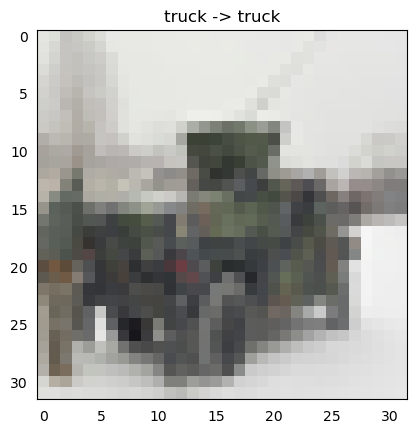

Key image: original prediction: truck edited prediction: truck


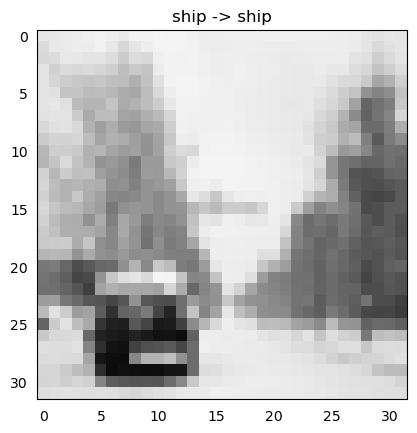

Value image: original prediction: ship edited prediction: ship


In [37]:
# Get features and logits of key, value, key neighbors and value neighbors before edit

# features
data_type = 'features'
pre_edit_features = pre_edit_knn[data_type]
pre_edit_key_features = pre_edit_features['anchor_data'][0]
pre_edit_key_neighbor_features = pre_edit_features['neighbor_data'][0]
pre_edit_key_neighbor_features_image_paths = pre_edit_features['image_paths'][0]

pre_edit_value_features = pre_edit_features['anchor_data'][1]
pre_edit_value_neighbor_features = pre_edit_features['neighbor_data'][1]
pre_edit_value_neighbor_features_image_paths = pre_edit_features['image_paths'][1]

# Repeat for after edit
post_edit_features = post_edit_knn[data_type]
post_edit_key_features = post_edit_features['anchor_data'][0]
post_edit_key_neighbor_features = post_edit_features['neighbor_data'][0]
post_edit_key_neighbor_features_image_paths = post_edit_features['image_paths'][0]


post_edit_value_features = post_edit_features['anchor_data'][1]
post_edit_value_neighbor_features = post_edit_features['neighbor_data'][1]
post_edit_value_neighbor_features_image_paths = post_edit_features['image_paths'][1]


# logits
data_type = 'logits'
pre_edit_logits = pre_edit_knn[data_type]
pre_edit_key_logits = pre_edit_logits['anchor_data'][0]
pre_edit_key_neighbor_logits = pre_edit_logits['neighbor_data'][0]
pre_edit_key_neighbor_logits_image_paths = pre_edit_logits['image_paths'][0]

pre_edit_value_logits = pre_edit_logits['anchor_data'][1]
pre_edit_value_neighbor_logits = pre_edit_logits['neighbor_data'][1]
pre_edit_value_neighbor_logits_image_paths = pre_edit_logits['image_paths'][1]


# Repeat for after edit
post_edit_logits = post_edit_knn[data_type]
post_edit_key_logits = post_edit_logits['anchor_data'][0]
post_edit_key_neighbor_logits = post_edit_logits['neighbor_data'][0]
post_edit_key_neighbor_logits_image_paths = post_edit_logits['image_paths'][0]


post_edit_value_logits = post_edit_logits['anchor_data'][1]
post_edit_value_neighbor_logits = post_edit_logits['neighbor_data'][1]
post_edit_value_neighbor_logits_image_paths = post_edit_logits['image_paths'][1]

pre_edit_key_prediction = class_list[np.argmax(pre_edit_key_logits)]
post_edit_key_prediction = class_list[np.argmax(post_edit_key_logits)]
visualizations.show_image(
    key_image,
    title="{} -> {}".format(pre_edit_key_prediction, post_edit_key_prediction),
    save_path=os.path.join(save_dir, "key_image.png"))

pre_edit_value_prediction = class_list[np.argmax(pre_edit_value_logits)]
post_edit_value_prediction = class_list[np.argmax(post_edit_value_logits)]
print("Key image: original prediction: {} edited prediction: {}".format(pre_edit_key_prediction, post_edit_key_prediction))
visualizations.show_image(
    value_image,
    title="{} -> {}".format(pre_edit_value_prediction, post_edit_value_prediction),
    save_path=os.path.join(save_dir, "value_image.png"))
print("Value image: original prediction: {} edited prediction: {}".format(pre_edit_value_prediction, post_edit_value_prediction))

### Features Visualizations

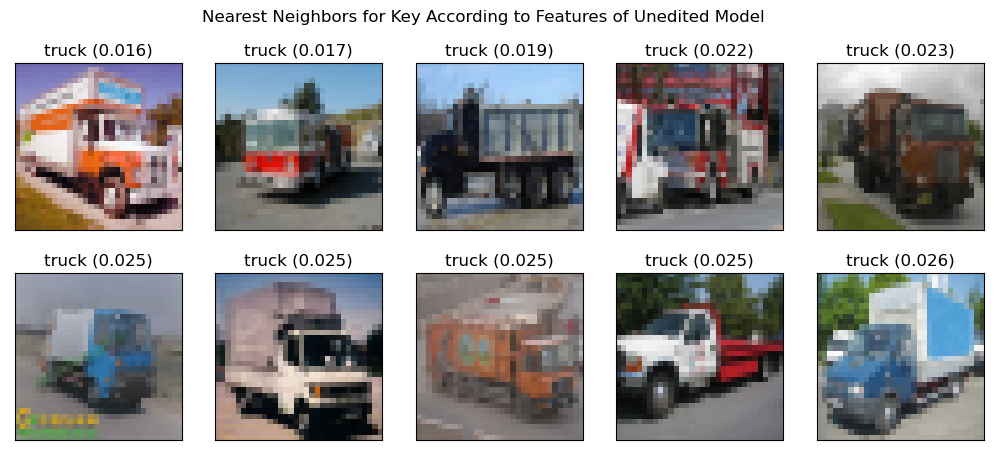

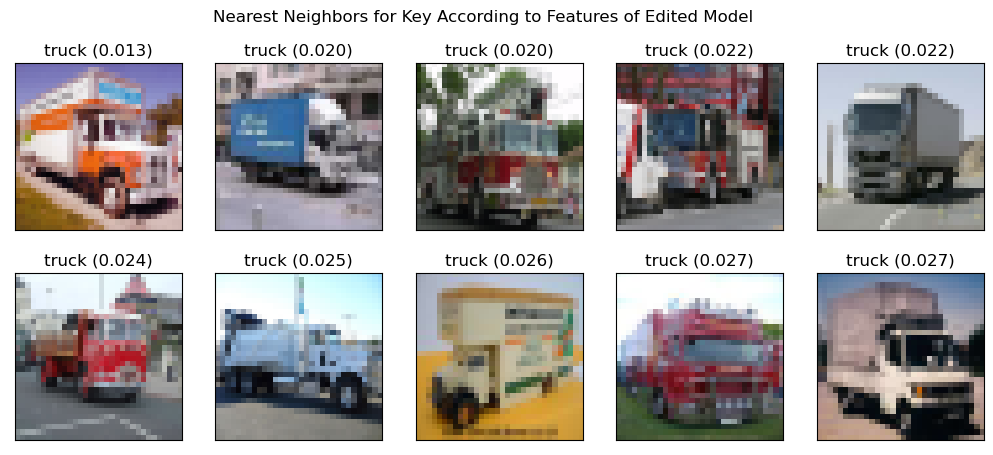

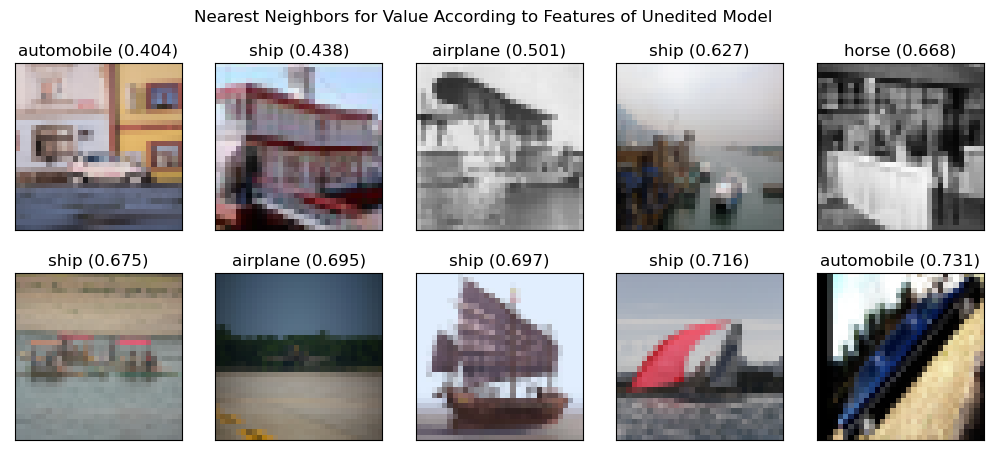

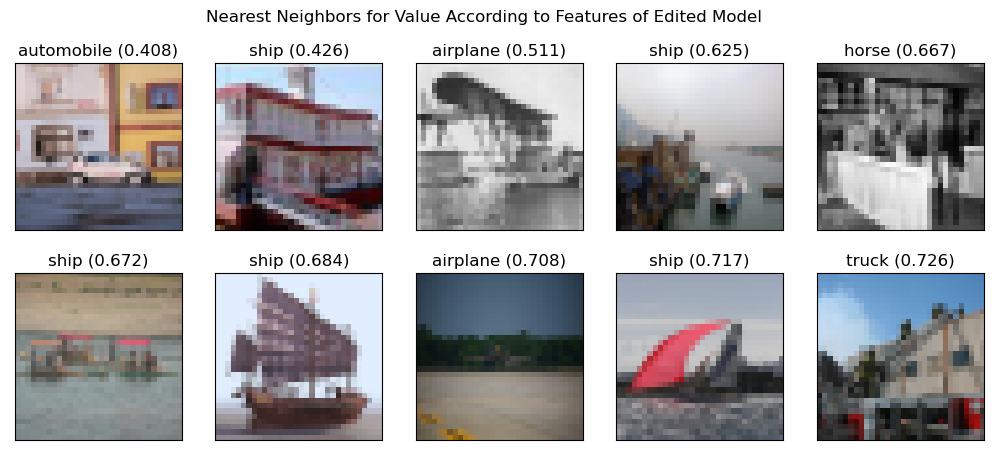

In [38]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
# data_type = 'features'
# pre_edit_feature_knn = pre_edit_knn['features']
# post_edit_feature_knn = post_edit_knn['features']

# Pre edit features for key (tank2)
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_key_neighbors_features.png"))

# Post edit features for key (tank2)
show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_key_neighbors_features.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_value_neighbors_features.png"))

show_results(
    results=post_edit_features, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_value_neighbors_features.png"))


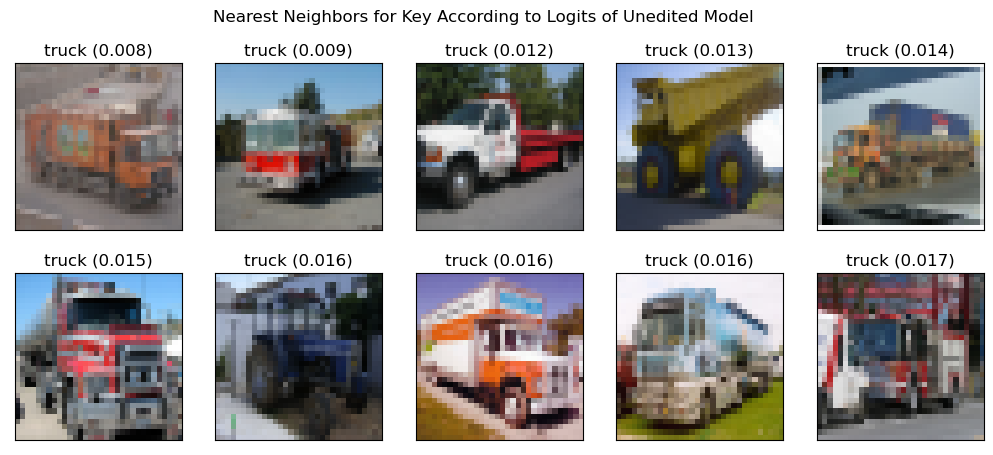

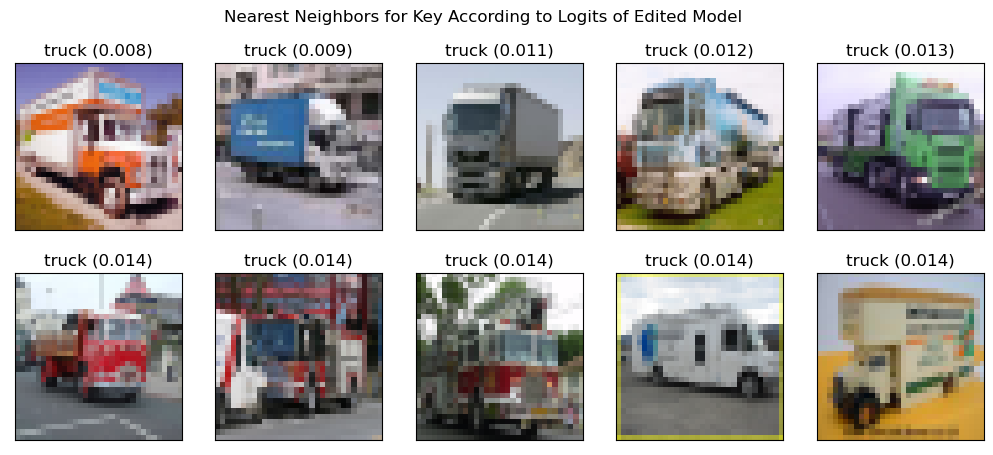

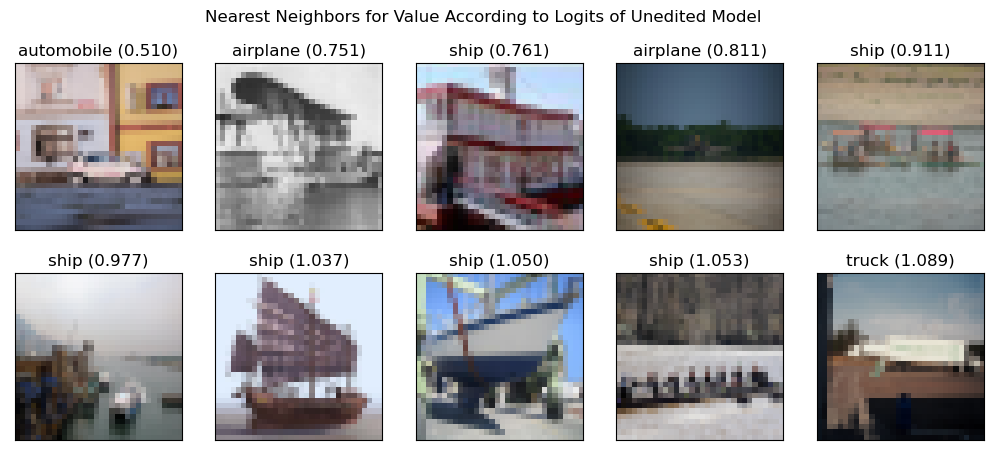

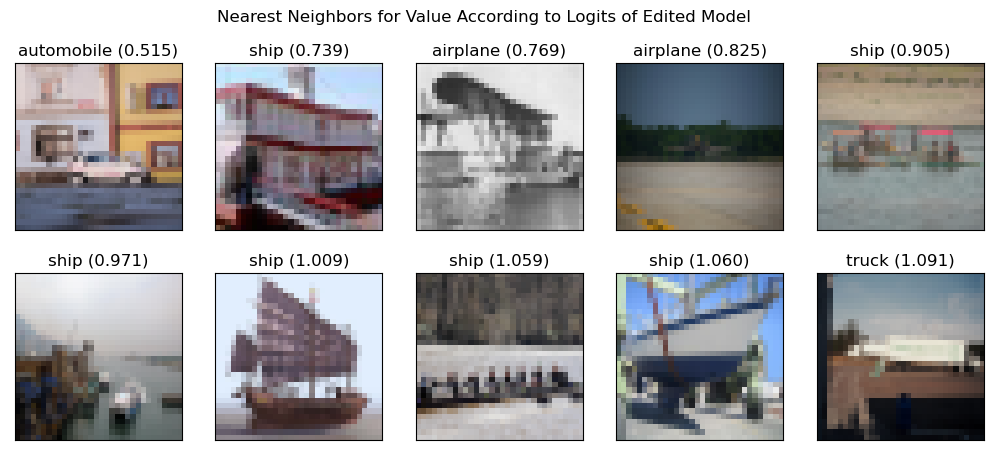

In [39]:
# LOGITS
# pre_edit_logits_knn = pre_edit_knn['logits']
# post_edit_logits_knn = post_edit_knn['logits']

# Logits for key (tank2)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_key_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_key_neighbors_logits.png"))

# Logits for value (tank1)
show_results(
    results=pre_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Unedited Model',
    save_path=os.path.join(save_dir, "pre_edit_value_neighbors_logits.png"))
show_results(
    results=post_edit_logits, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Edited Model',
    save_path=os.path.join(save_dir, "post_edit_value_neighbors_logits.png"))

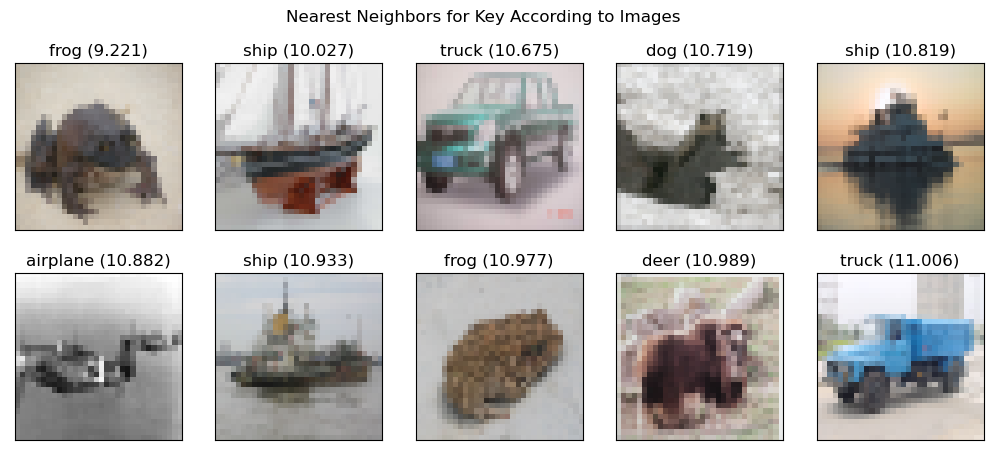

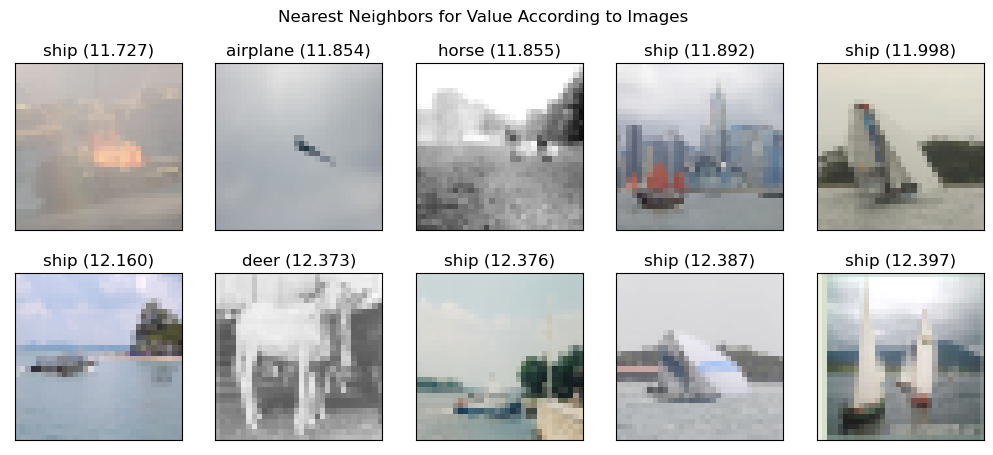

In [40]:
# IMAGES
pre_edit_images_knn = pre_edit_knn['images']
post_edit_images_knn = post_edit_knn['images']
# Features for key (tank2)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Images',
    save_path=os.path.join(save_dir, "key_neighbors_images.png"))

# Features for value (tank1)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Images',
    save_path=os.path.join(save_dir, "value_neighbors_images.png"))

### Given neighbors of the value image, find distances from key

In [41]:
from scipy.spatial import distance
def calculate_distance(u, v, metric='minkowski'):
    if metric == 'minkowski':
        return distance.minkowski(u, v)
    else:
        raise ValueError("Distance metric {} not supported.".format(metric))

In [42]:
# def calculate_distances(
#     vectors, 
#     anchor, 
#     metric='minkowski'):
#     '''
#     Given a list of vectors, calculate the distances from anchor using metric provided

#     Arg(s):
#         vectors : N x D np.array or list[np.array]
#             N vectors of same shape of anchor
#         anchor : D-dim np.vector
#             Point to calculate distance from
#         metric : str
#             type of distance metric to use

#     Returns:
#         N-dim np.array : list of distances from anchor point
#     '''
#     distances = []
#     for vector in vectors:
#         distance = calculate_distance(vector, anchor, metric=metric)
#         distances.append(distance)
    
#     distances = np.stack(distances, axis=0)

#     return distances

In [43]:
# Sanity check that A's neighbors get the correct distances in feature space

features_results = pre_edit_knn['images']
knn_distances = features_results['distances'][0]
knn_image_paths = features_results['image_paths'][0]
flattened_key_image = np.copy(key_image)
flattened_key_image = flattened_key_image.flatten()

images = []
for path in knn_image_paths:
    
    image = load_image(path, resize=IMAGE_SIZE)
    image = image.flatten()
    images.append(image)

distances = calculate_distances(
    vectors=images,
    anchor=flattened_key_image
)
for knn_dist, minkowski_dist in zip(knn_distances, distances):
    assert np.abs(knn_dist - minkowski_dist) < 1e-5

### Key Image Neighbor Analysis

Find the top neighbors of the key image before the edit
Calculate the distances in the feature and logit space to the value image before and after the edit and see how they differ.

How to take into account the changes in the value image's representation in the feature and logit space due to the edit as well?

### Comparing Key Image with Value Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [44]:
log("Key image with value neighbors", log_path)
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_key_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_key_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_key_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_key_features)

log("Features", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_features_distances), log_path)
log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(post_key_to_pre_value_neighbors_edited_features_distances), log_path)
log("", log_path)


Key image with value neighbors
Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[5.04363108 4.65878773 5.36646366 4.94654846 4.92967272 4.75551939
 5.17016268 4.59332752 5.16325426 5.13076687 4.50430107 4.68370676
 4.82999897 5.02379799 5.59491396 5.136446   4.62324333 4.52053165
 5.53004169 5.31238985 5.03049469 5.40293074 5.21878958 5.30606699
 5.05415392 5.01594019 5.79510736 4.48317289 5.69406033 5.56528091
 5.26015663 5.43772984 4.54820299 4.25663757 4.90393162 5.90773582
 4.12786198 5.80459023 5.07970762 5.58408403 4.86128616 5.74959803
 5.33395386 5.92048693 5.62112522 4.51628685 5.77822304 4.93665218
 4.87465    4.80271292 5.85795116 4.81841516 4.75906515 4.56905937
 5.00118589 5.6055851  5.0275569  5.75118303 4.33285666 5.78417921
 5.90962315 5.59924316 5.69844961 4.52071095 5.61100101 5.74111938
 4.86852169 5.27535868 4.78627729 5.1839838  4.9712882  4.28503513
 5.87400293 4.27458763 4.97550583 4.9001689  5.34127188 5.96514654
 4.397

### Comparing Key Image with Value Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [45]:
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate distances between key and neighbors of value before the edit
pre_key_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_key_logits)

pre_key_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_key_logits)

log("Logits", log_path)
log("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_logits_distances), log_path, log_path)
log("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model", log_path)
log(str(pre_key_to_pre_value_neighbors_edited_logits_distances), log_path)
log("", log_path)
log("---***---", log_path)

Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[8.57816887 9.06408119 7.82026291 8.58194828 8.07354259 8.17204475
 7.56702852 8.64208603 8.80364895 8.78062153 8.72517014 8.61029434
 8.36286068 8.71695328 8.63439083 7.72865248 8.19836998 8.33193207
 9.12752819 8.39920807 8.56418514 8.91472816 7.77394962 8.36970329
 7.85093021 7.52811575 9.57175159 8.94248581 8.72475147 8.57559967
 9.43502522 9.34828091 8.50815105 9.19624043 9.40098953 8.5998497
 8.93841743 8.20520592 8.76015663 7.58045006 8.69449329 8.67926598
 7.57715225 8.02352333 9.49965382 7.56837463 9.25187111 8.48483467
 9.2275877  7.21332502 8.59101105 9.43366909 7.4008894  9.66994858
 8.21679688 9.66459274 9.90708351 7.61320734 7.40901661 7.9402318
 9.33121109 8.05674171 7.89013481 8.6374464  8.82098866 8.12155056
 8.1175127  8.99700546 7.79671288 8.78904152 7.72798538 9.24034595
 9.49774933 8.10691357 9.70756531 7.28050804 7.73430109 8.59505558
 8.95687008 9.02000237 9.76092911 8.52826

### Comparing Value Image with Key Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [46]:
# Load images that are the pre-edit neighbors of key
# Only looking at features
log("Value Image with Key Neighbors", log_path)
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_value_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_value_features)

log("Features", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_key_neighbors_features_distances), log_path)
log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_key_neighbors_edited_features_distances), log_path)
log("", log_path)

Value Image with Key Neighbors
Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[4.99107838 4.97724104 4.98610067 4.98945236 4.97886229 4.99050951
 4.9711628  4.98194504 4.9804945  4.97598743 4.9659586  4.98781013
 4.98652601 4.98776054 4.98446751 5.00062943 4.9940877  4.99473095
 4.97635651 4.97019625 4.9725256  4.99116564 4.98248434 4.98075008
 4.96453524 4.98317623 4.98332977 4.98541164 4.96399975 4.98315096
 4.98613167 4.97997093 4.9836936  4.98507023 4.99692059 4.96796656
 4.98360348 4.97620964 4.98080254 4.99538088 5.00302982 4.97027445
 4.96472454 4.97448587 4.96644258 4.98409796 4.96329498 4.99219227
 4.98133039 4.97807646 4.96482801 4.96482801 4.96748304 4.99456501
 5.00077629 4.98632383 4.98831367 4.96754217 5.00871134 4.97421026
 4.99066925 4.96336126 4.98889685 4.97206497 4.97308683 4.96126556
 4.98440742 4.95948124 4.98445034 4.97347879 4.96625614 5.00821114
 4.99412394 4.98227262 4.97108984 4.96752596 4.98015356 5.00888681
 4.980

### Comparing Value Image with Key Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [47]:
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_logits_images)

# Move  logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_value_logits)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_value_logits)

log("logits", log_path)
log("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model", log_path)
log(str(pre_value_to_pre_key_neighbors_logits_distances), log_path)
log("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model", log_path)
log(str(post_value_to_pre_key_neighbors_edited_logits_distances), log_path)


logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[8.42645836 8.42615986 8.42682648 8.43187904 8.42827511 8.43152142
 8.42214966 8.44179249 8.440938   8.44065857 8.42739391 8.44037342
 8.4170742  8.43466568 8.42765141 8.43476772 8.41196346 8.43264198
 8.41699123 8.42479897 8.43860245 8.4142704  8.44305992 8.41911983
 8.41898155 8.4376173  8.44042492 8.42529488 8.42478466 8.44459724
 8.41461945 8.43711758 8.42691612 8.43434238 8.43103027 8.41885853
 8.44108963 8.42348003 8.43002415 8.43171883 8.44234562 8.4277153
 8.42855453 8.43001556 8.4143362  8.41431236 8.44536591 8.43226528
 8.44951439 8.44465542 8.40805531 8.43279362 8.44429874 8.41835213
 8.41717148 8.42943382 8.43061161 8.42329407 8.42775249 8.44446278
 8.42073059 8.42573738 8.4071207  8.44963551 8.43751812 8.40625954
 8.43505859 8.4407196  8.44780827 8.43364906 8.43992233 8.40473366
 8.41120434 8.42675591 8.42049789 8.41278553 8.42296791 8.44758511
 8.40664005 8.42594337 8.40880966 8.4355